In [1]:
import cmocean.cm as cm
import copy
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from salishsea_tools import viz_tools

In [2]:
# mesh mask file for land mask
meshmask = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
tmask = meshmask.tmask[0]
# ensure tmask has same dimensions as field

In [3]:
# make land versions of cmaps, land is grey
cm_salt = copy.copy(cm.haline)
cm_salt.set_bad('grey')
cm_bwr = copy.copy(cm.balance)
cm_bwr.set_bad('grey')
cm_temp = copy.copy(cm.thermal)
cm_temp.set_bad('grey')
cm_vel = copy.copy(cm.curl)
cm_vel.set_bad('grey')

In [4]:
base = xr.open_dataset('/data/sallen/results/MEOPAR/wastewater/base_again/SalishSea_1h_20230301_20230301_grid_T.nc')
tands = xr.open_dataset('/data/sallen/results/MEOPAR/wastewater/tands//SalishSea_1h_20230301_20230301_grid_T.nc')
tands5 = xr.open_dataset('/data/sallen/results/MEOPAR/wastewater/tands_5day/SalishSea_1h_20230301_20230305_grid_T.nc')
tands5

<xarray.Dataset>
Dimensions:               (y: 898, x: 398, nvertex: 4, deptht: 40,
                           axis_nbounds: 2, time_counter: 120)
Coordinates:
    nav_lat               (y, x) float32 ...
    nav_lon               (y, x) float32 ...
  * deptht                (deptht) float32 0.5 1.5 2.5 3.5 ... 387.6 414.5 441.5
    time_centered         (time_counter) datetime64[ns] ...
  * time_counter          (time_counter) datetime64[ns] 2023-03-01T00:30:00 ....
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    bounds_nav_lon        (y, x, nvertex) float32 ...
    bounds_nav_lat        (y, x, nvertex) float32 ...
    area                  (y, x) float32 ...
    deptht_bounds         (deptht, axis_nbounds) float32 ...
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] ...
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] ...
    sossheig              (time_counter, y, x) float32 ...
    votemper              (time_counter, deptht, y, x) float32 ...
    vosaline              (time_counter, deptht, y, x) float32 ...
    sigma_theta           (time_counter, deptht, y, x) float32 ...
    e3t                   (time_counter, deptht, y, x) float32 ...
Attributes:
    name:         SalishSea_1h_20230301_20230305_grid_T
    description:  physics tracers and VVL layer thicknesses
    title:        physics tracers and VVL layer thicknesses
    Conventions:  CF-1.6
    timeStamp:    2023-Sep-17 17:18:03 GMT
    uuid:         a3cdeeae-5d2f-46ce-b251-0779e83d2e76

In [5]:
def get_uw(dir, it, x_slice, yvalue):
    # read in both the u and v velocity components
    base_u = xr.open_dataset(f'/data/sallen/results/MEOPAR/wastewater/{dir}/SalishSea_1h_20230301_20230301_grid_U.nc')
    base_w = xr.open_dataset(f'/data/sallen/results/MEOPAR/wastewater/{dir}/SalishSea_1h_20230301_20230301_grid_W.nc')

# the u velocity is staggered in the x direction, unstagger it
    u_region = viz_tools.unstagger_xarray(
        base_u.vozocrtx.isel(time_counter=it, y=yvalue, x=x_slice), 'x')

# the w velocity is staggered in the z direction, unstagger it
    w_region = viz_tools.unstagger_xarray(
        base_w.vovecrtz.isel(time_counter=it, y=yvalue, x=x_slice), 'depthw')
    w_region['depthw'] = u_region.depthu.values
    w_region.rename({'depthw': 'depthu'})
    
# merge u and w into one dataset, dropping the now inaccurate nav_lon and nav_lat varaiables
    base_uw = xr.merge([u_region.rename({'depthu': 'deptht'}).drop(['nav_lon', 'nav_lat']), 
                    w_region.rename({'depthw': 'deptht'}).drop(['nav_lon', 'nav_lat'])])
    
    print(base_uw)
    base_uw = base_uw.assign(grid_X=lambda alpha: alpha.x)
    print(base_uw)

    return base_u.vozocrtx.isel(time_counter=it, y=yvalue, x=x_slice), base_w.vovecrtz.isel(time_counter=it, y=yvalue, x=x_slice), u_region, w_region, base_uw

In [6]:
iz = 30  # width of domain plotted
y_slice=slice(400+iz, 500-iz)
x_slice=slice(250+iz, 350-iz)
u_staggered, w_staggered, u_region, w_region, base_uw = get_uw('base_again', 23, x_slice, 446)

<xarray.Dataset>
Dimensions:        (deptht: 40, x: 40)
Coordinates:
  * deptht         (deptht) float32 0.5 1.5 2.5 3.5 ... 360.7 387.6 414.5 441.5
    time_centered  datetime64[ns] 2023-03-01T23:30:00
    time_counter   datetime64[ns] 2023-03-01T23:30:00
Dimensions without coordinates: x
Data variables:
    vozocrtx       (deptht, x) float32 nan 0.2037 0.139 0.136 ... 0.0 0.0 0.0
    vovecrtz       (deptht, x) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0
<xarray.Dataset>
Dimensions:        (deptht: 40, x: 40)
Coordinates:
  * deptht         (deptht) float32 0.5 1.5 2.5 3.5 ... 360.7 387.6 414.5 441.5
    time_centered  datetime64[ns] 2023-03-01T23:30:00
    time_counter   datetime64[ns] 2023-03-01T23:30:00
Dimensions without coordinates: x
Data variables:
    vozocrtx       (deptht, x) float32 nan 0.2037 0.139 0.136 ... 0.0 0.0 0.0
    vovecrtz       (deptht, x) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    grid_X         (x) int64 0 1 2 3 4 5 6 7 8 9 ... 31 32 33 34 35 36 3

In [53]:
base_slice = base.votemper.isel(y = 446, x = x_slice)
base_slice
base_scale = base_slice.assign_coords(x = base_slice.coords["x"] * 440)
base_scale

<xarray.DataArray 'votemper' (time_counter: 24, deptht: 40, x: 40)>
[38400 values with dtype=float32]
Coordinates:
    nav_lat        (x) float32 ...
    nav_lon        (x) float32 ...
  * deptht         (deptht) float32 0.5 1.5 2.5 3.5 ... 360.7 387.6 414.5 441.5
    time_centered  (time_counter) datetime64[ns] ...
  * time_counter   (time_counter) datetime64[ns] 2023-03-01T00:30:00 ... 2023...
  * x              (x) int64 0 440 880 1320 1760 ... 15840 16280 16720 17160
Attributes:
    standard_name:       sea_water_conservative_temperature
    long_name:           Conservative Temperature
    units:               degree_C
    online_operation:    average
    interval_operation:  40 s
    interval_write:      1 h
    cell_methods:        time: mean (interval: 40 s)
    cell_measures:       area: area

(200.0, 0.0)

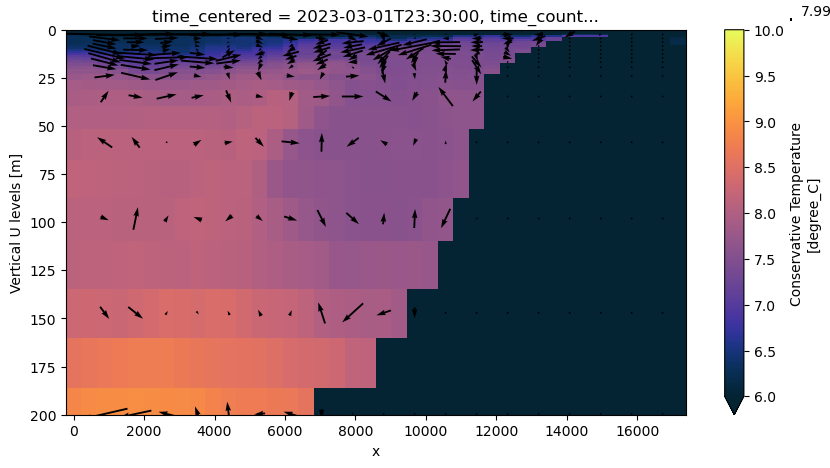

In [54]:
step = 2
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
base_uw['x'] = base_uw.grid_X * 440

base_scale.isel(time_counter = 23).plot(ax = ax, cmap = cm_temp, vmax = 10, vmin = 6, yincrease = False)
ax.set_ylim(200, 0)

# need to invert w as we plot z increasing downward
base_uw['w_inverse'] = -base_uw.vovecrtz
quiver_plot =  (base_uw.isel(x=slice(None, None, step), deptht=slice(None, None,step))
            .plot.quiver(x='x', y='deptht', u='vozocrtx', v='w_inverse', 
                            pivot='mid', angles='xy', scale_units='xy', scale=0.0001, ax=ax))
ax.set_ylim(200, 0)

In [7]:
#tand_five = tands5.votemper.isel(y = 446, x = x_slice)
tand_five_last_day = tands5.isel(time_counter = slice(96, 120), x = x_slice)
tand_five_last_day = tand_five_last_day.assign_coords(x = tand_five_last_day.coords["x"] * 440)
tand_five_last_day

<xarray.Dataset>
Dimensions:               (y: 898, x: 40, nvertex: 4, deptht: 40,
                           axis_nbounds: 2, time_counter: 24)
Coordinates:
    nav_lat               (y, x) float32 ...
    nav_lon               (y, x) float32 ...
  * deptht                (deptht) float32 0.5 1.5 2.5 3.5 ... 387.6 414.5 441.5
    time_centered         (time_counter) datetime64[ns] ...
  * time_counter          (time_counter) datetime64[ns] 2023-03-05T00:30:00 ....
  * x                     (x) int64 0 440 880 1320 ... 15840 16280 16720 17160
Dimensions without coordinates: y, nvertex, axis_nbounds
Data variables:
    bounds_nav_lon        (y, x, nvertex) float32 ...
    bounds_nav_lat        (y, x, nvertex) float32 ...
    area                  (y, x) float32 ...
    deptht_bounds         (deptht, axis_nbounds) float32 ...
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] ...
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] ...
    sossheig              (time_counter, y, x) float32 ...
    votemper              (time_counter, deptht, y, x) float32 ...
    vosaline              (time_counter, deptht, y, x) float32 ...
    sigma_theta           (time_counter, deptht, y, x) float32 ...
    e3t                   (time_counter, deptht, y, x) float32 ...
Attributes:
    name:         SalishSea_1h_20230301_20230305_grid_T
    description:  physics tracers and VVL layer thicknesses
    title:        physics tracers and VVL layer thicknesses
    Conventions:  CF-1.6
    timeStamp:    2023-Sep-17 17:18:03 GMT
    uuid:         a3cdeeae-5d2f-46ce-b251-0779e83d2e76

(200.0, 0.0)

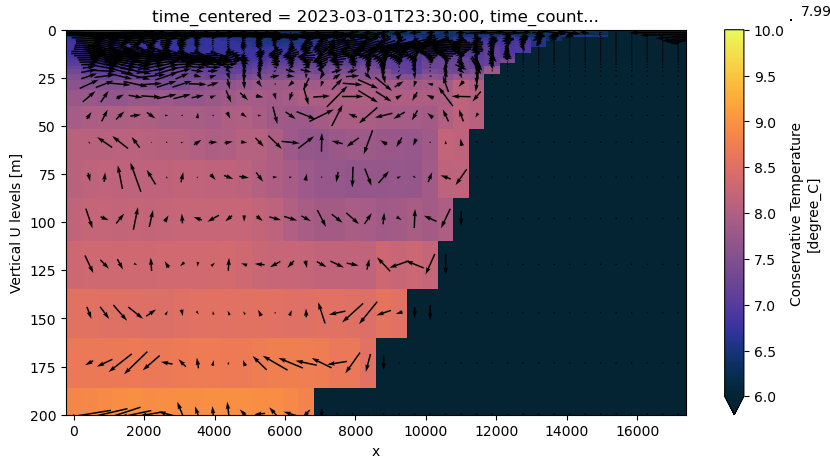

In [8]:
#plots for tands_five
step = 1
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
base_uw['x'] = base_uw.grid_X * 440

tand_five_last_day.votemper.isel(time_counter = 23, y = 446).plot(ax = ax, cmap = cm_temp, vmax = 10, vmin = 6, yincrease = False)
ax.set_ylim(200, 0)

# need to invert w as we plot z increasing downward
base_uw['w_inverse'] = -base_uw.vovecrtz
quiver_plot =  (base_uw.isel(x=slice(None, None, step), deptht=slice(None, None,step))
            .plot.quiver(x='x', y='deptht', u='vozocrtx', v='w_inverse', 
                            pivot='mid', angles='xy', scale_units='xy', scale=0.0001, ax=ax))
ax.set_ylim(200, 0)